In [53]:
import AnalysisFunctions as af

import pandas as pd  
#defaultdict to use nested dictionaries
from collections import defaultdict

import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import dill

from IPython.display import IFrame

# 1. Pre-processing:

- Choose the initialization time of the simulation, 
- Organize the runoff and precipitation data in dataframes altogether with their respective observation intervals
- Calculate the quantiles on the distribution of ensemble forecasts 
- Calculate the runoff meteorological medians out of the set of realizations

In [2]:
# Dictionary initialization:
df = af.dictionary()

In [3]:
# Decide simulation initialization time:
sim_start = '2018-10-26 12:00:00'

In [4]:
# Some parameters for the basin:
Verzasca_area = 186*1000.0**2 #m2
conv_factor = Verzasca_area/(1000.0*3600.0) 

In [10]:
# Runoff observation: open observation dataframe
obs_pattern = '/home/ciccuz/hydro/prevah/runoff/2605.dat'
obs_columns = ['year','month','day','hour','runoff']
obs_df = pd.DataFrame(pd.read_csv(obs_pattern, names=obs_columns, delim_whitespace=True, header=None))
obs_df['date'] = pd.to_datetime(obs_df[['year', 'month', 'day', 'hour']])


# Precipitation observation: open precipitation observation dataframe obtained by cosmo1+pluviometer 
#data concatenated series before the initialization of the model
prec_obs_df = af.dictionary(pattern="/home/ciccuz/hydro/PrecObs/cosmo1_{simul_time}/{otherstuff}",
                        folders_pattern = '/home/ciccuz/hydro/PrecObs/cosmo1_*')
prec_obs_series= dill.load( open( "prec_obs/prec_obs_series.txt", "rb" ) )

In [11]:
# Extract from the dictionary the dataframe containing all the different realizations of the same event: 
#every ensemble member and parameter set combination for the runoff, every ensemble member for the precipitation.
ens_df_prec = af.ensemble_df(df, sim_start, Verzasca_area, 'P-kor')
ens_df_runoff = af.ensemble_df(df, sim_start, Verzasca_area,'RGES')

In [12]:
# Calculate the quantiles for the variable chosen considering all the different realizations for the 120h ahead.
quant_prec = af.quantiles(ens_df_prec)
quant_runoff = af.quantiles(ens_df_runoff)

In [13]:
# Define the subset of runoff and precipitation observation based on quantiles dataframe date boundaries
obs_indexes_runoff = obs_df.loc[obs_df.index[obs_df['date'] == str(quant_runoff.date[0])] |
        obs_df.index[obs_df['date'] == str(quant_runoff.date[119])]]
obs_indexes_prec = prec_obs_series.loc[prec_obs_series.index[prec_obs_series['date'] == str(quant_runoff.date[0])] |
        prec_obs_series.index[prec_obs_series['date'] == str(quant_runoff.date[119])]]

obs_subset = obs_df.loc[obs_indexes_runoff.index[0]:obs_indexes_runoff.index[1]]
prec_obs_subset = prec_obs_series.loc[obs_indexes_prec.index[0]:obs_indexes_prec.index[1]]

In [14]:
# Meteorological medians:
# Select groups of realizations based on the same ensemble members:
# dictionaries sorted by ensemble members
rm_groups_runoff = af.ens_param_groups(ens_df_runoff)[0]

# Quantiles dictionaries from above rm groups dictionary
quant_rm_dict = lambda: defaultdict(quant_rm_dict)
quant_rm_groups_runoff = quant_rm_dict()

for rm in range(21):
    quant_rm_groups_runoff[rm] = af.quantiles(rm_groups_runoff[rm])

# Construct a dataframe having all the medians obtained for every group of realizations 
# associated to an ens member
rm_medians = pd.DataFrame(index=range(120))

for rm in range(21):
    rm_medians[rm] = quant_rm_groups_runoff[rm]['0.5']
rm_medians['date'] = quant_rm_groups_runoff[rm]['date']

rm_medians.columns = ['rm00','rm01','rm02','rm03','rm04','rm05','rm06','rm07','rm08','rm09','rm10','rm11','rm12',
                     'rm13','rm14','rm15','rm16','rm17','rm18','rm19','rm20','date']

# Quantiles on rm medians:
quant_rm_medians = af.quantiles(rm_medians)

## 1.1. Spaghetti and hydrograph plotting for the entire set of realizations:

One forecast initialization comprises 120 hourly values of forecast, the number of runoff forecasts for every initialization is given by the product of the ensemble members of the meteorological model (21 ens) and the set of hydrological parameters that have been made randomly change (25 pin), so 525. The precipitation forecasts are given by the 21 ensemble members composing the meteorological model.

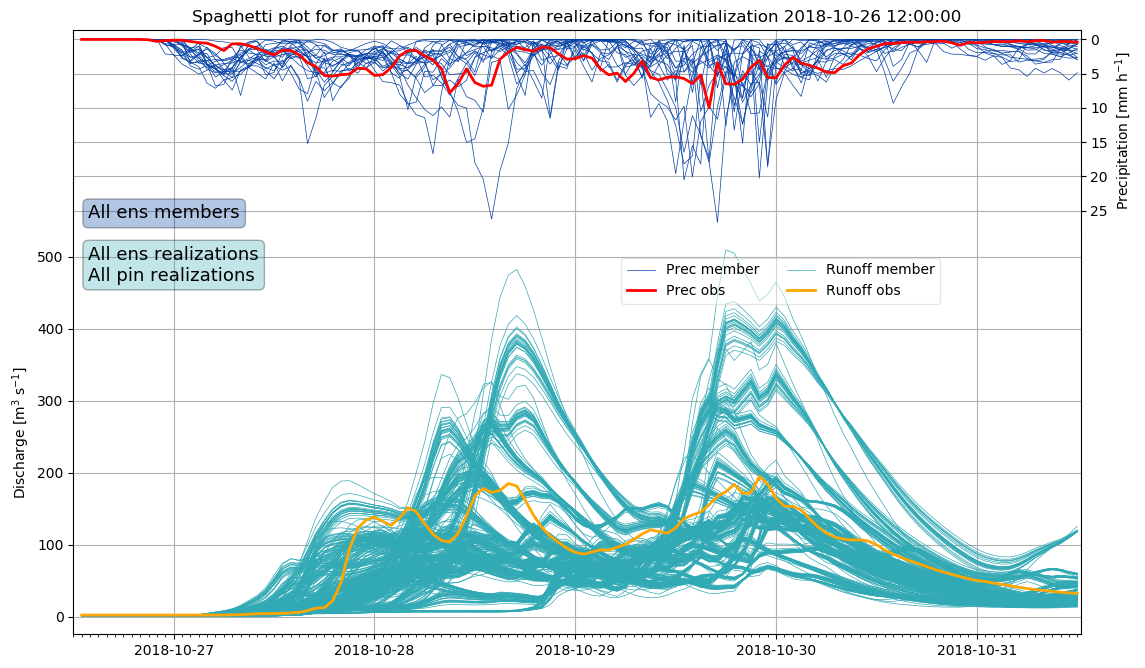

In [15]:
#Spaghetti plot: 
af.spaghetti_plot(ens_df_runoff, ens_df_prec, obs_subset, prec_obs_subset, sim_start)

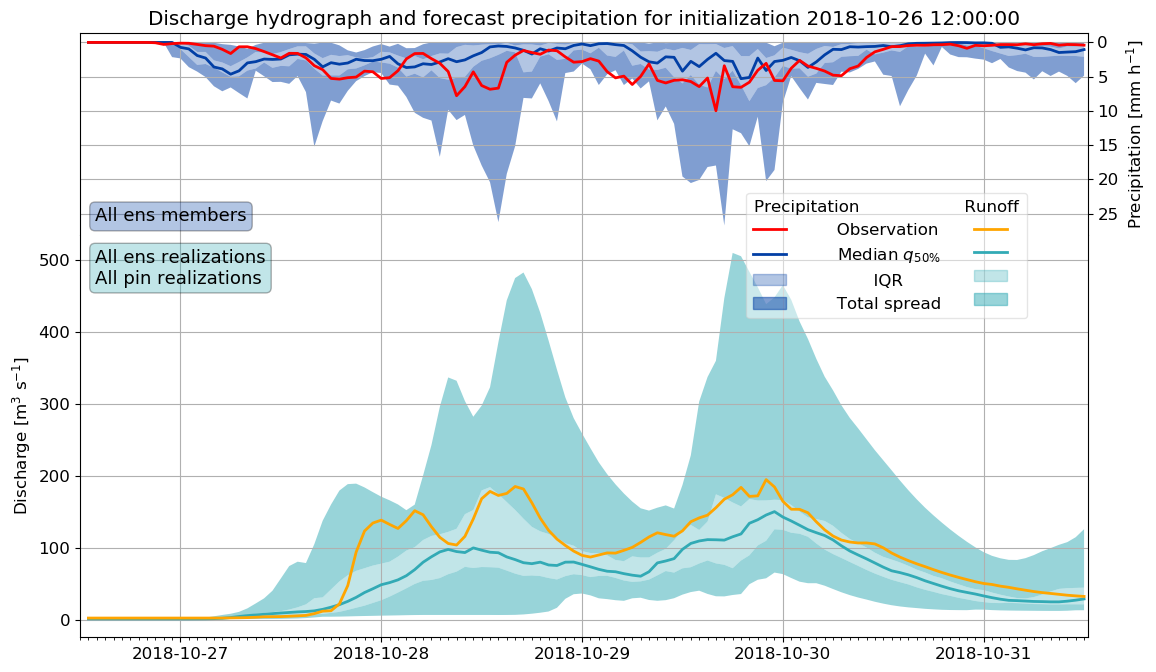

In [16]:
# Hydrograph:
af.hydrograph(quant_runoff, quant_prec, obs_subset, prec_obs_subset, sim_start)

# 2. Separate different sources of uncertainty:

## 2.1. Meteorological uncertainty:

To have a look at how the meteorological uncertainty impact on the forecast take the meteorological medians (i.e. the 21 medians around the 25 different sets of hydrological parameters) and look at the resulting spread of the simulation.

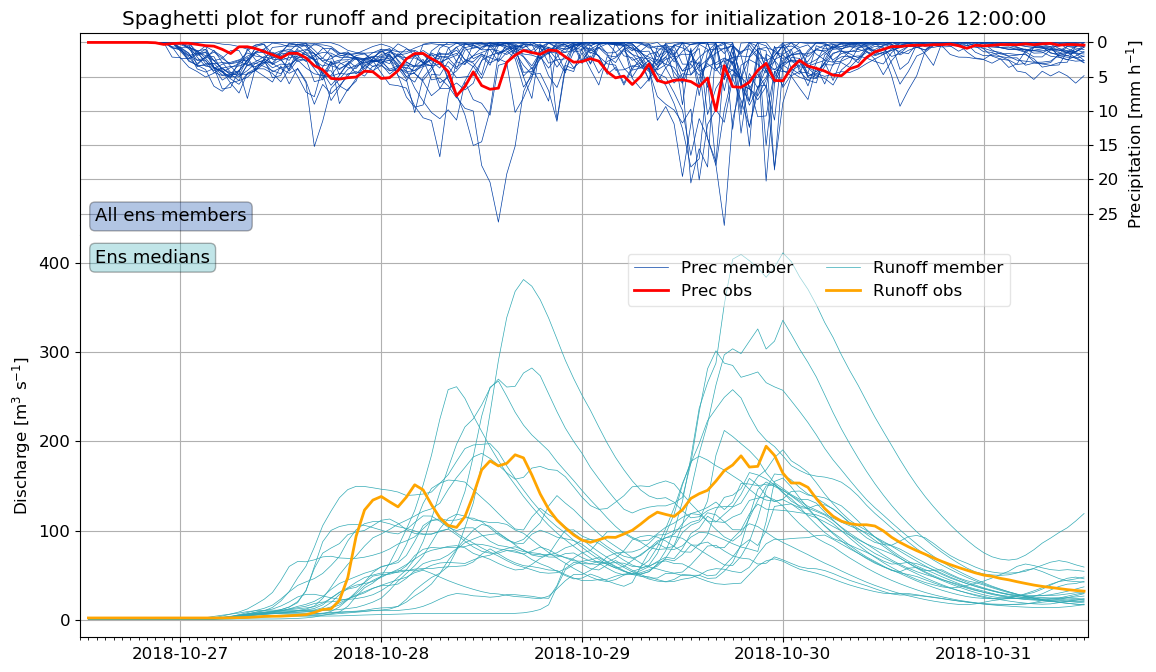

In [17]:
#Spaghetti plot with the 21 rm medians: 
af.spaghetti_plot(rm_medians, ens_df_prec, obs_subset, prec_obs_subset, sim_start, medians=True)

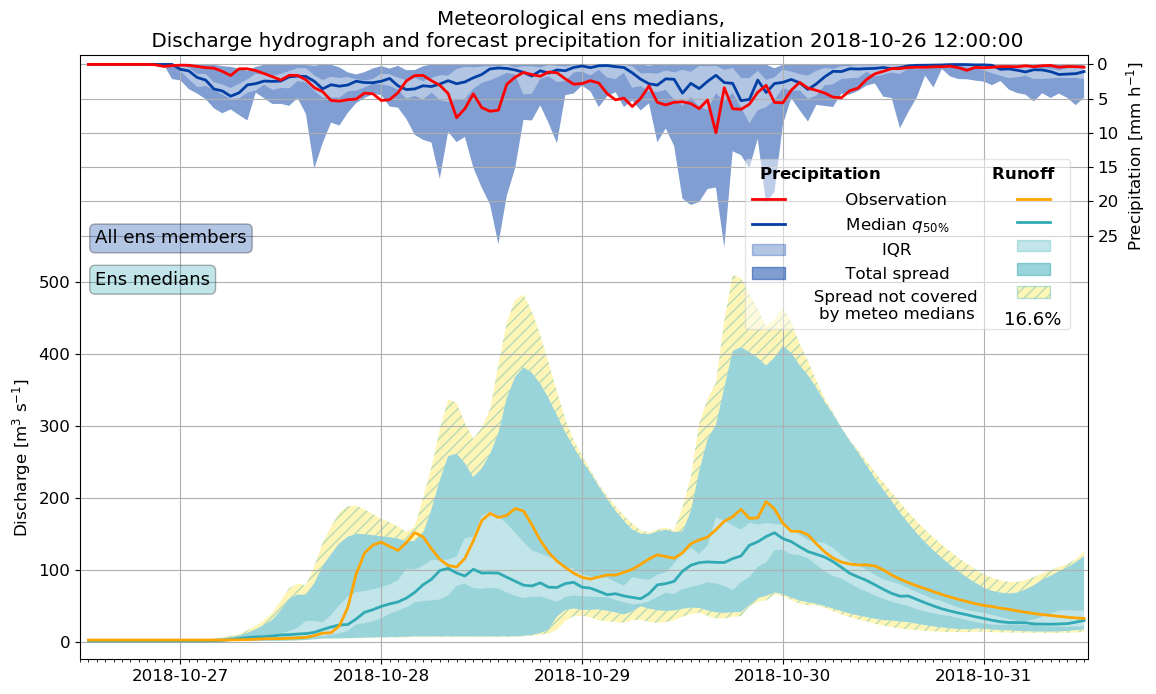

In [19]:
# Quantify the meteorological uncertainty by plotting the range of spread among all the 21 rm medians obtained:
#af.hydrograph(quant_rm_medians, quant_prec, obs_subset, prec_obs_subset, sim_start, medians=True)
af.comparison_meteo_hydrograph(quant_rm_medians, quant_runoff, quant_prec, obs_subset, prec_obs_subset, sim_start)[1]

## 2.2. Thinning of the spread

Remove spread extremes to try to obtain a sharper forecast, more compact around the observation

In [20]:
#for every leadtime find maximum and minimum value and its realization of fcst runoff:
max_runoff = pd.DataFrame(index=range(120), columns=['runoff', 'member'])
min_runoff = pd.DataFrame(index=range(120), columns=['runoff', 'member'])

for leadtime in range(120):
    max_runoff['runoff'][leadtime] = ens_df_runoff.loc[:, ens_df_runoff.columns != 'date'].loc[[leadtime]].max(axis=1).values[0]
    max_runoff['member'][leadtime] = (list(ens_df_runoff.loc[:, ens_df_runoff.columns != 'date'].loc[[leadtime]].stack().idxmax()))[1]
    
    min_runoff['runoff'][leadtime] = ens_df_runoff.loc[:, ens_df_runoff.columns != 'date'].loc[[leadtime]].min(axis=1).values[0]
    min_runoff['member'][leadtime] = (list(ens_df_runoff.loc[:, ens_df_runoff.columns != 'date'].loc[[leadtime]].stack().idxmin()))[1]
    
    
#remove from dataframe the meteo member related to the maximum/minimum runoff: replace those member with NaNs
ens_df_runoff_thin = ens_df_runoff.copy()
for leadtime in range(120):
    ens_df_runoff_thin.replace(ens_df_runoff_thin.loc[[leadtime]].filter(regex=max_runoff.loc[[leadtime]]['member'].values[0][:4]), 
                               np.nan, inplace=True)
    ens_df_runoff_thin.replace(ens_df_runoff_thin.loc[[leadtime]].filter(regex=min_runoff.loc[[leadtime]]['member'].values[0][:4]), 
                               np.nan, inplace=True)
    
#calculate quantiles on this new set of data:
quant_runoff_thin = af.quantiles(ens_df_runoff_thin)

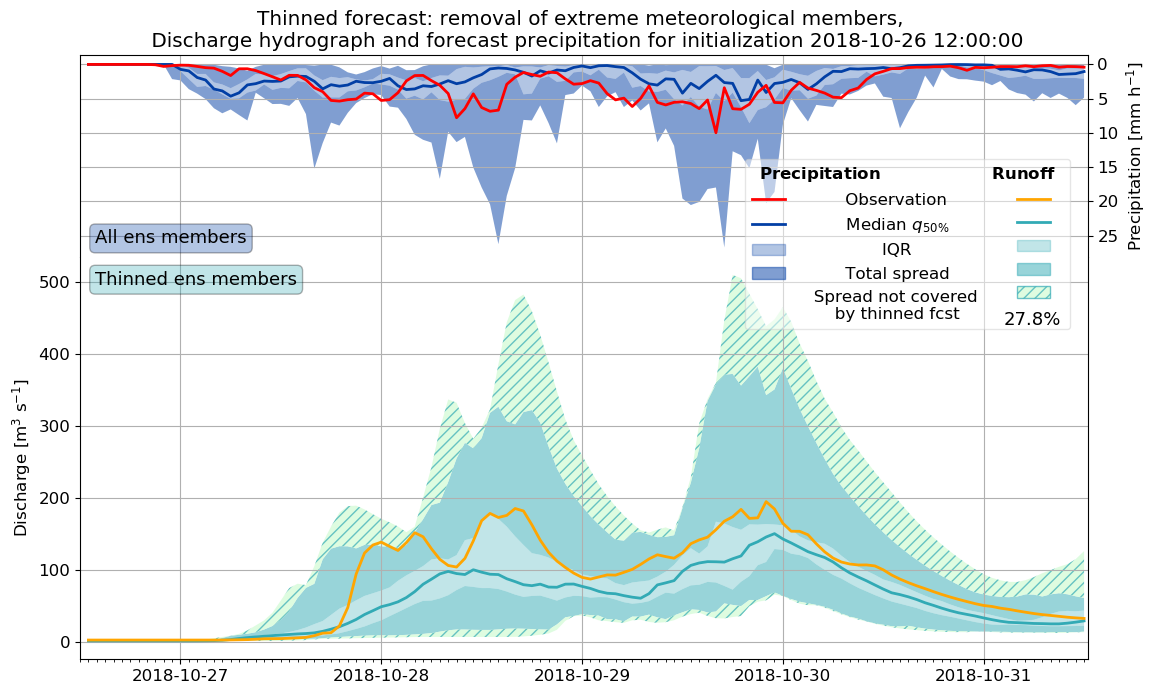

In [21]:
af.comparison_meteo_hydrograph(quant_runoff_thin, quant_runoff, quant_prec, obs_subset, prec_obs_subset, sim_start, thinning=True)[1]

## 2.3. Hydrological parameters uncertainty:

Look for different ensemble realizations how the hydrological spread behaves: detect three realizations having different behaviours and plot the corresponding spread around their medians.

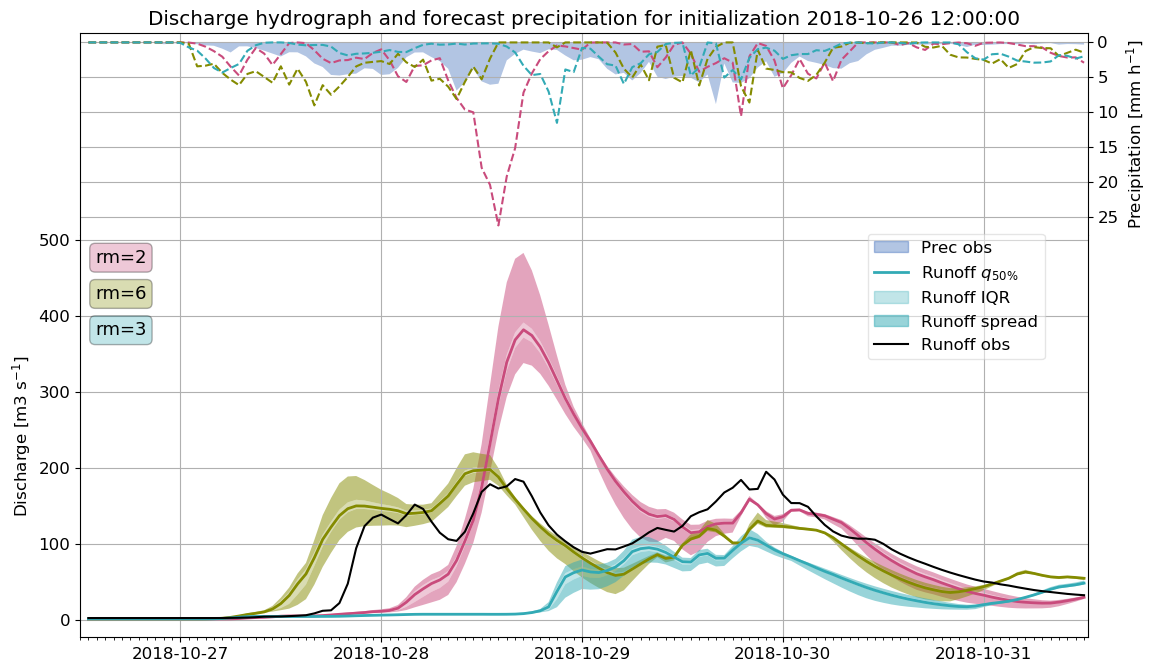

In [14]:
rm_high = 2
rm_medium = 6
rm_low = 3

af.hydrograph_rms(rm_high, rm_medium, rm_low, ens_df_prec, quant_rm_groups_runoff, quant_runoff, 
                  obs_subset, prec_obs_subset, sim_start)

Quantify the hydrological uncertainty considering the spread between the quantiles around every meteorological median: for every meteo median, in every hourly point, report the total spread range and the IQR and normalize it with the median value of discharge in that point.

In [69]:
IFrame("./hydro_unc/102312_to_103112_newIntervals.pdf", width=950, height=650)

## 2.4. Hydrological parameters uncertainty in the past

Look at the 5 days before the initialization date

In [13]:
past_sim_start = str(ens_df_runoff.date[119])

past_ens_df = af.past_hydro_unc_ensemble_df(df, past_sim_start, Verzasca_area, 'RGES') 

past_quant = af.quantiles(past_ens_df)

past_obs_indexes_runoff = obs_df.loc[obs_df.index[obs_df['date'] == str(past_quant.date[0])] |
        obs_df.index[obs_df['date'] == str(past_quant.date[119])]]
past_obs_indexes_prec = prec_obs_series.loc[prec_obs_series.index[prec_obs_series['date'] == str(past_quant.date[0])] |
        prec_obs_series.index[prec_obs_series['date'] == str(past_quant.date[119])]]

past_obs_subset = obs_df.loc[past_obs_indexes_runoff.index[0]:past_obs_indexes_runoff.index[1]]
past_prec_obs_subset = prec_obs_series.loc[past_obs_indexes_prec.index[0]:past_obs_indexes_prec.index[1]]

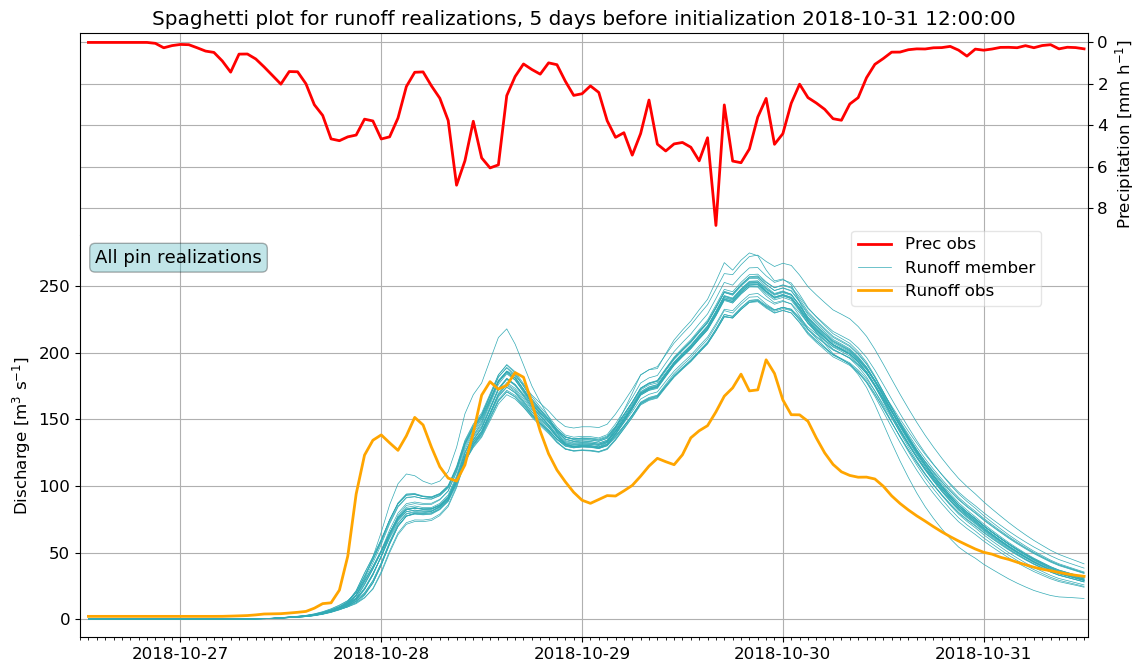

In [14]:
af.spaghetti_plot(past_ens_df, ens_df_prec, past_obs_subset, past_prec_obs_subset, past_sim_start, past=True)

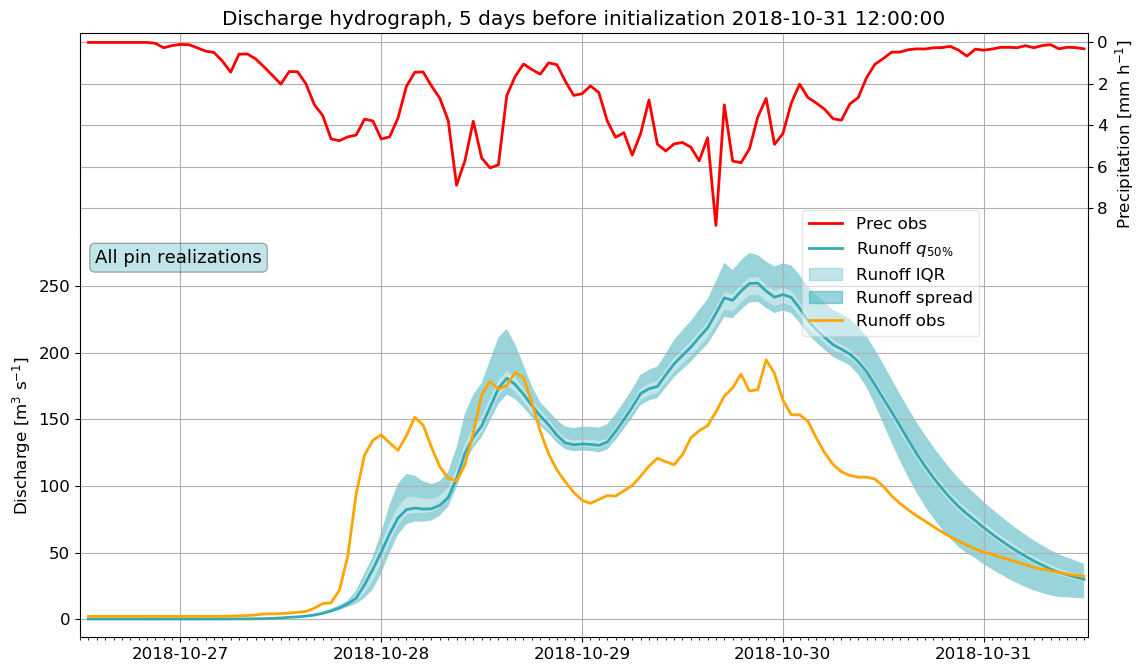

In [15]:
af.hydrograph(past_quant, quant_prec, past_obs_subset, past_prec_obs_subset, past_sim_start, past=True)

# 3. Peak-box approach:
Application of the algorithm developed to construct multiple peak-boxes related to different peak events, as an extension of the algorithm developed in Zappa et al. (2013).

In [10]:
import individual_scripts.peakbox_classic_multipeaksV3_cluster as pbk

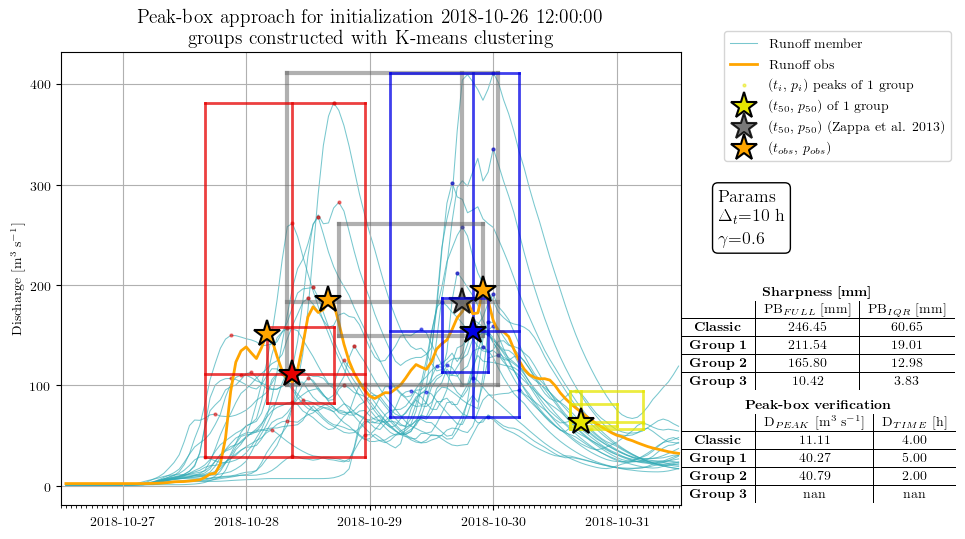

In [11]:
pbk.peak_box_multipeaks_kmeans(rm_medians, obs_subset, sim_start, delta_t=10, gamma=0.6)

In [12]:
sim_start2 = '2018-11-10 00:00:00'

ens_df_runoff2 = af.ensemble_df(df, sim_start2, Verzasca_area,'RGES')
quant_runoff2 = af.quantiles(ens_df_runoff2)
obs_indexes_runoff2 = obs_df.loc[obs_df.index[obs_df['date'] == str(quant_runoff2.date[0])] |
        obs_df.index[obs_df['date'] == str(quant_runoff2.date[119])]]
obs_subset2 = obs_df.loc[obs_indexes_runoff2.index[0]:obs_indexes_runoff2.index[1]]
rm_groups_runoff2 = af.ens_param_groups(ens_df_runoff2)[0]
quant_rm_groups_runoff2 = quant_rm_dict()

for rm in range(21):
    quant_rm_groups_runoff2[rm] = af.quantiles(rm_groups_runoff2[rm])

rm_medians2 = pd.DataFrame(index=range(120))

for rm in range(21):
    rm_medians2[rm] = quant_rm_groups_runoff2[rm]['0.5']
rm_medians2['date'] = quant_rm_groups_runoff2[rm]['date']

rm_medians2.columns = ['rm00','rm01','rm02','rm03','rm04','rm05','rm06','rm07','rm08','rm09','rm10','rm11','rm12',
                     'rm13','rm14','rm15','rm16','rm17','rm18','rm19','rm20','date']

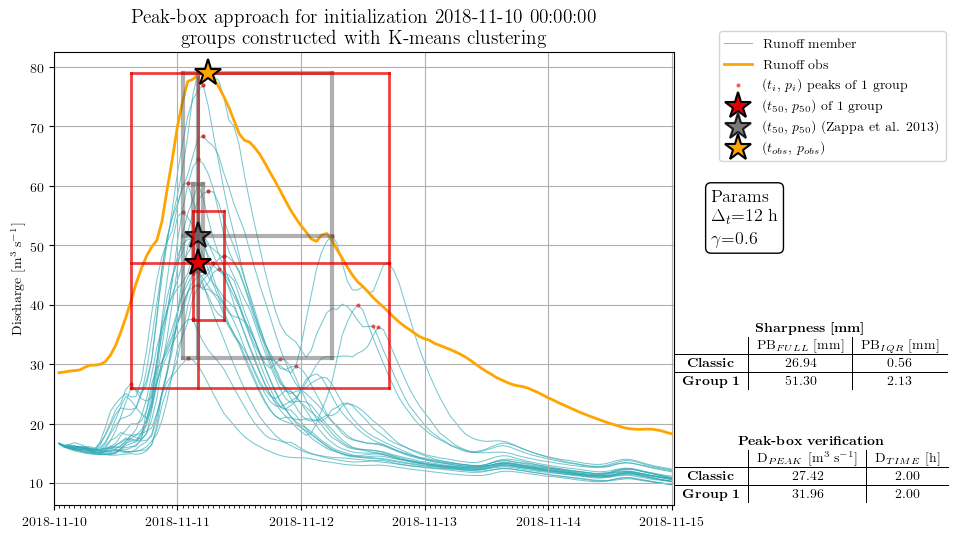

In [14]:
pbk.peak_box_multipeaks_kmeans(rm_medians2, obs_subset2, sim_start2, delta_t=12, gamma=0.6)

# 4. Cluster analysis

In [58]:
import individual_scripts.cluster_funct as cl

Perform a hierarchical agglomerative complete-linkage cluster analysis on the meteorological precipitation ensemble members and extract a restricted number of representative members. Goal: check whether the representative members extracted from the few clusters (3-5-7) we obtain are able to give similar/worst/better forecasts than by using the entire set of ensemble forecasts (21), and see which part of the spread are able to cover.

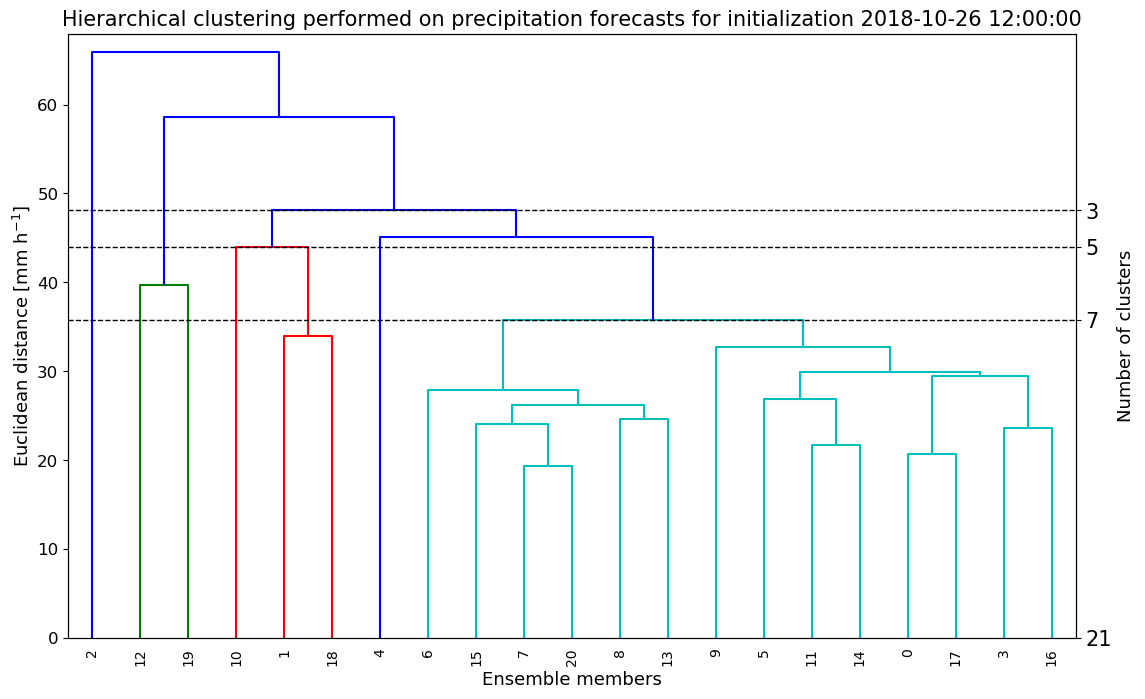

In [59]:
#Plot the dendrogram: visualization of the clustering algorithm applied
cl.clustered_dendrogram(ens_df_prec.drop('date', axis=1), sim_start)
plt.show()

In [60]:
#Choose the number of clusters (3 or 5):
Nclusters = 3

#extract the representative members
RM = cl.clustered_RM(ens_df_prec.drop('date', axis=1), sim_start, Nclusters)

#extract the sub-dataframe for prec and runoff forecasts containing only the members related to the new extracted representative members:
clust_ens_df_prec = pd.DataFrame()
clust_ens_df_runoff = pd.DataFrame()

for rm_index in range(Nclusters):
    clust_ens_df_prec = pd.concat([clust_ens_df_prec, ens_df_prec.loc[:, ens_df_prec.columns == f'rm{RM[rm_index]:02d}_pin01']], axis=1, sort=False)
    for pin in range(1,26):
        clust_ens_df_runoff = pd.concat([clust_ens_df_runoff, ens_df_runoff.loc[:, ens_df_runoff.columns == f'rm{RM[rm_index]:02d}_pin{pin:02d}']], axis=1, sort=False)

clust_ens_df_prec = pd.concat([clust_ens_df_prec, ens_df_prec.date], axis=1)
clust_ens_df_runoff = pd.concat([clust_ens_df_runoff, ens_df_runoff.date], axis=1)

# Cluster quantiles:
clust_quant_prec = af.quantiles(clust_ens_df_prec)
clust_quant_runoff = af.quantiles(clust_ens_df_runoff)

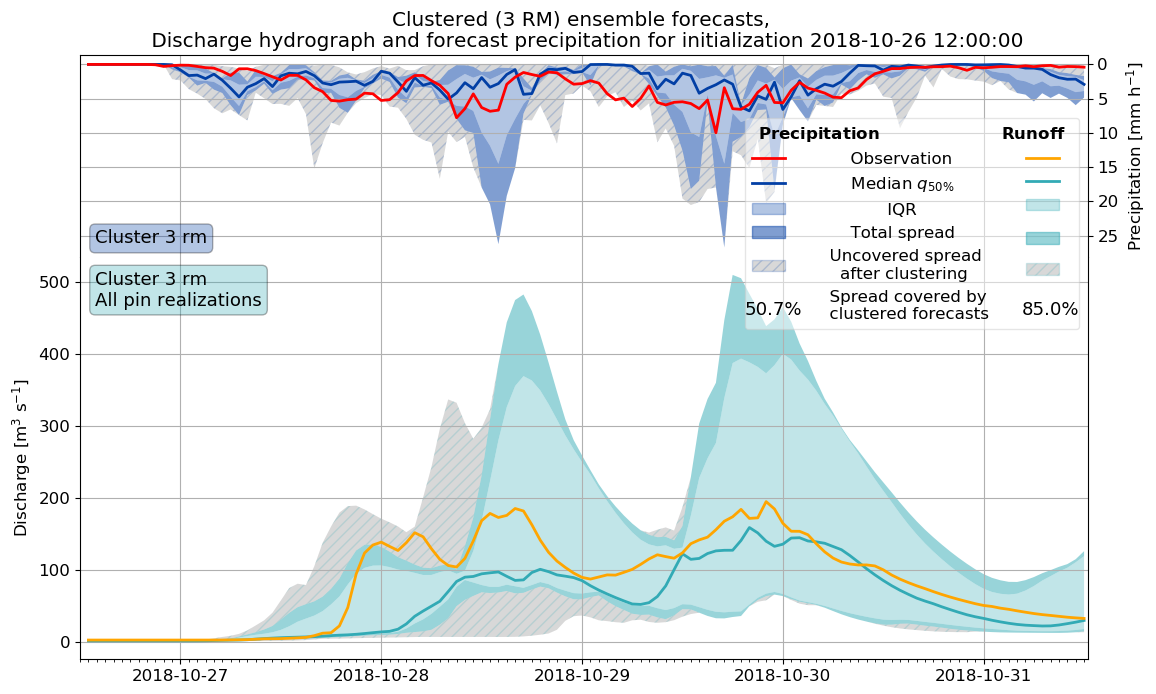

In [62]:
# Hydrograph plot of clustered forecasts
cl.cluster_hydrograph(clust_quant_runoff, clust_quant_prec, quant_runoff, quant_prec, obs_subset, prec_obs_subset, sim_start, Nclusters=Nclusters)[2]

In [64]:
#Choose the number of clusters (3 or 5):
Nclusters = 5

#extract the representative members
RM = cl.clustered_RM(ens_df_prec.drop('date', axis=1), sim_start, Nclusters)

#extract the sub-dataframe for prec and runoff forecasts containing only the members related to the new extracted representative members:
clust_ens_df_prec = pd.DataFrame()
clust_ens_df_runoff = pd.DataFrame()

for rm_index in range(Nclusters):
    clust_ens_df_prec = pd.concat([clust_ens_df_prec, ens_df_prec.loc[:, ens_df_prec.columns == f'rm{RM[rm_index]:02d}_pin01']], axis=1, sort=False)
    for pin in range(1,26):
        clust_ens_df_runoff = pd.concat([clust_ens_df_runoff, ens_df_runoff.loc[:, ens_df_runoff.columns == f'rm{RM[rm_index]:02d}_pin{pin:02d}']], axis=1, sort=False)

clust_ens_df_prec = pd.concat([clust_ens_df_prec, ens_df_prec.date], axis=1)
clust_ens_df_runoff = pd.concat([clust_ens_df_runoff, ens_df_runoff.date], axis=1)

# Cluster quantiles:
clust_quant_prec = af.quantiles(clust_ens_df_prec)
clust_quant_runoff = af.quantiles(clust_ens_df_runoff)

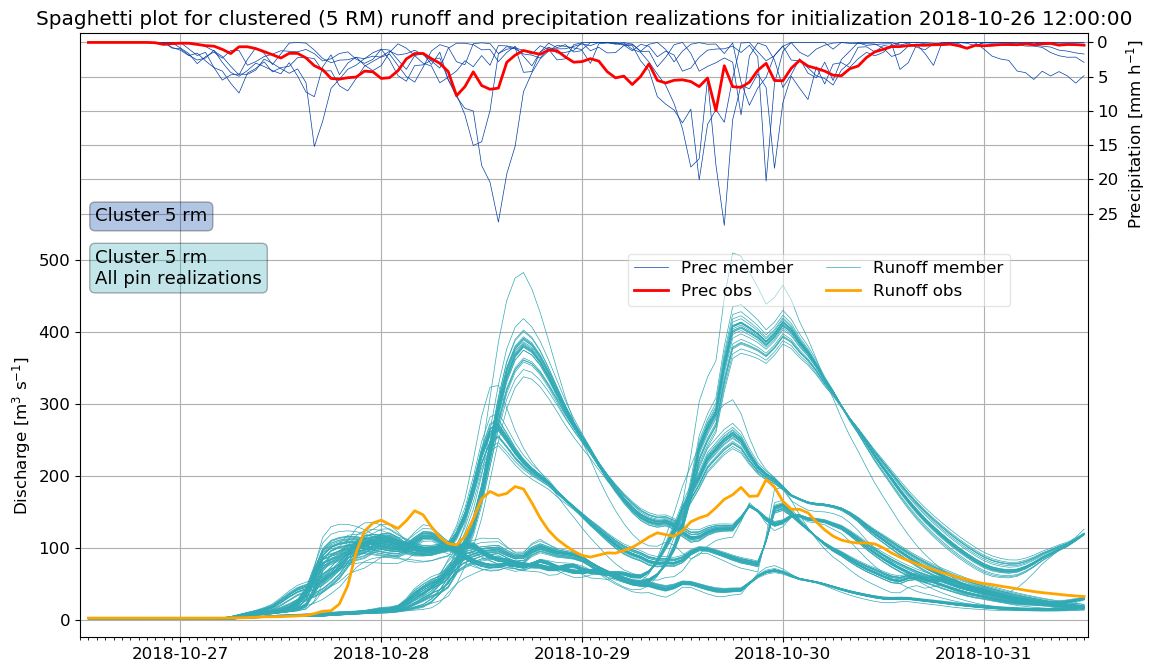

In [65]:
# Spaghetti plot of clustered forecasts
af.spaghetti_plot(clust_ens_df_runoff, clust_ens_df_prec, obs_subset, prec_obs_subset, sim_start, clustered=True)

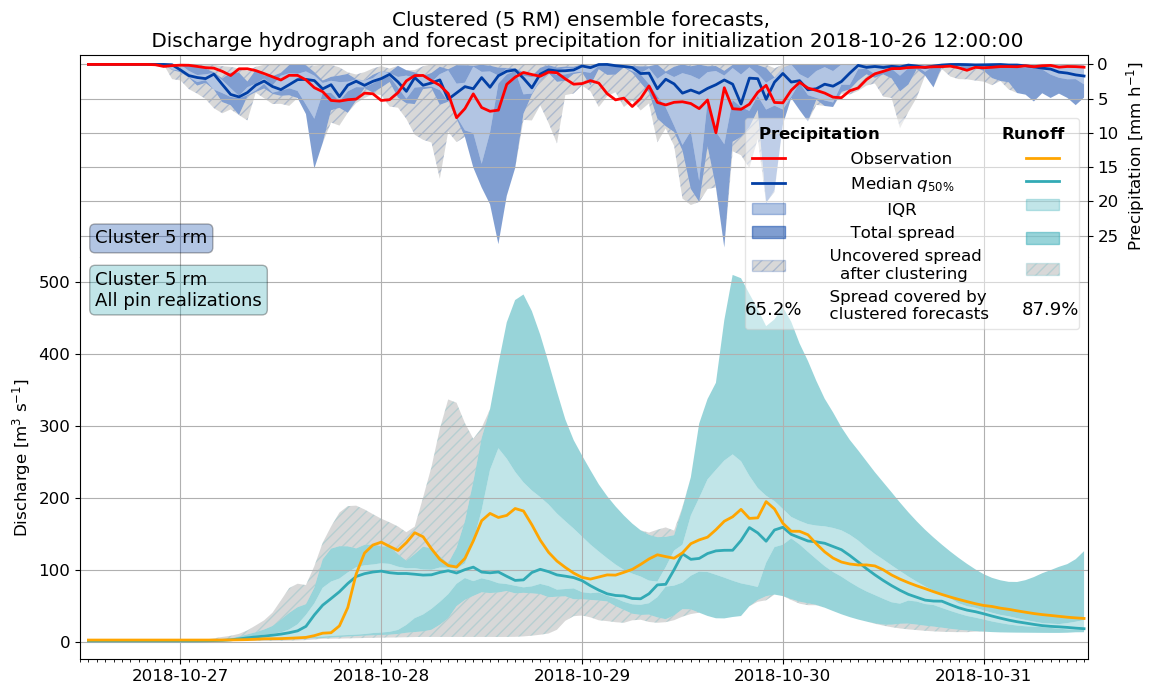

In [66]:
# Hydrograph plot of clustered forecasts
cl.cluster_hydrograph(clust_quant_runoff, clust_quant_prec, quant_runoff, quant_prec, obs_subset, prec_obs_subset, sim_start, Nclusters=Nclusters)[2]

In [67]:
#Choose the number of clusters (3 or 5):
Nclusters = 7

#extract the representative members
RM = cl.clustered_RM(ens_df_prec.drop('date', axis=1), sim_start, Nclusters)

#extract the sub-dataframe for prec and runoff forecasts containing only the members related to the new extracted representative members:
clust_ens_df_prec = pd.DataFrame()
clust_ens_df_runoff = pd.DataFrame()

for rm_index in range(Nclusters):
    clust_ens_df_prec = pd.concat([clust_ens_df_prec, ens_df_prec.loc[:, ens_df_prec.columns == f'rm{RM[rm_index]:02d}_pin01']], axis=1, sort=False)
    for pin in range(1,26):
        clust_ens_df_runoff = pd.concat([clust_ens_df_runoff, ens_df_runoff.loc[:, ens_df_runoff.columns == f'rm{RM[rm_index]:02d}_pin{pin:02d}']], axis=1, sort=False)

clust_ens_df_prec = pd.concat([clust_ens_df_prec, ens_df_prec.date], axis=1)
clust_ens_df_runoff = pd.concat([clust_ens_df_runoff, ens_df_runoff.date], axis=1)

# Cluster quantiles:
clust_quant_prec = af.quantiles(clust_ens_df_prec)
clust_quant_runoff = af.quantiles(clust_ens_df_runoff)

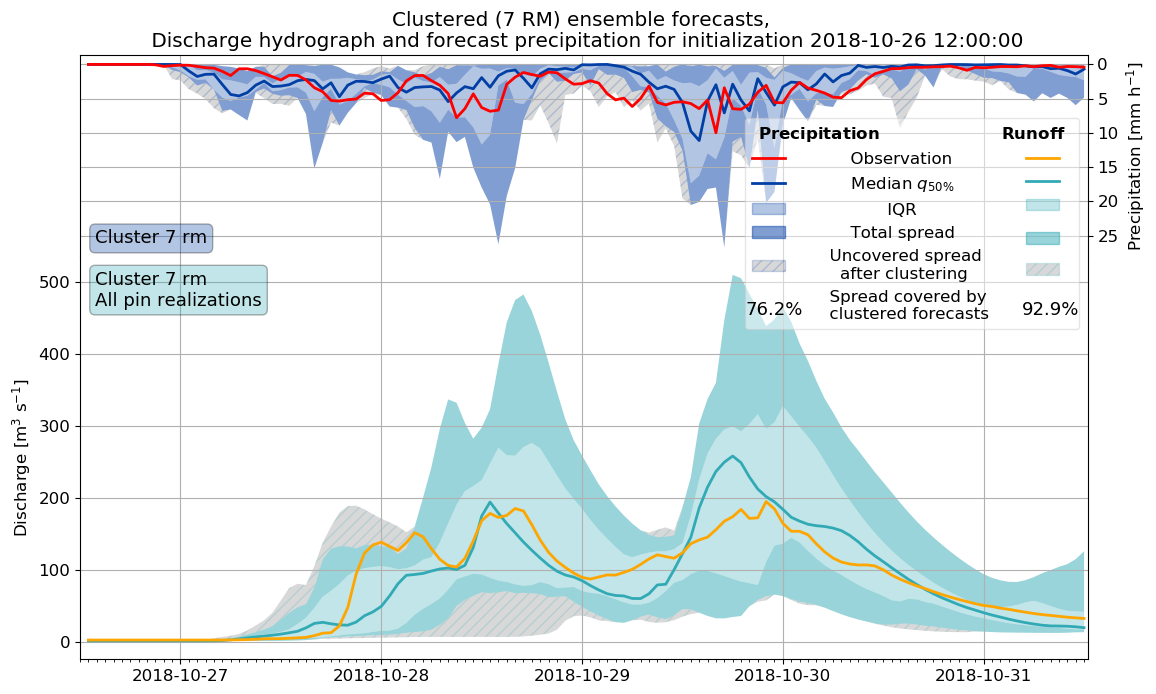

In [68]:
# Hydrograph plot of clustered forecasts
cl.cluster_hydrograph(clust_quant_runoff, clust_quant_prec, quant_runoff, quant_prec, obs_subset, prec_obs_subset, sim_start, Nclusters=Nclusters)[2]